<a href="https://colab.research.google.com/github/donank/ML-Crash-Course-Google-Developers/blob/main/feature_engineering_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case Study 1

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.




In [328]:
import csv
import numpy as np
%config InlineBackend.figure_formats = ['svg']

from matplotlib import pyplot as plt
%matplotlib inline

In [329]:
# load data
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

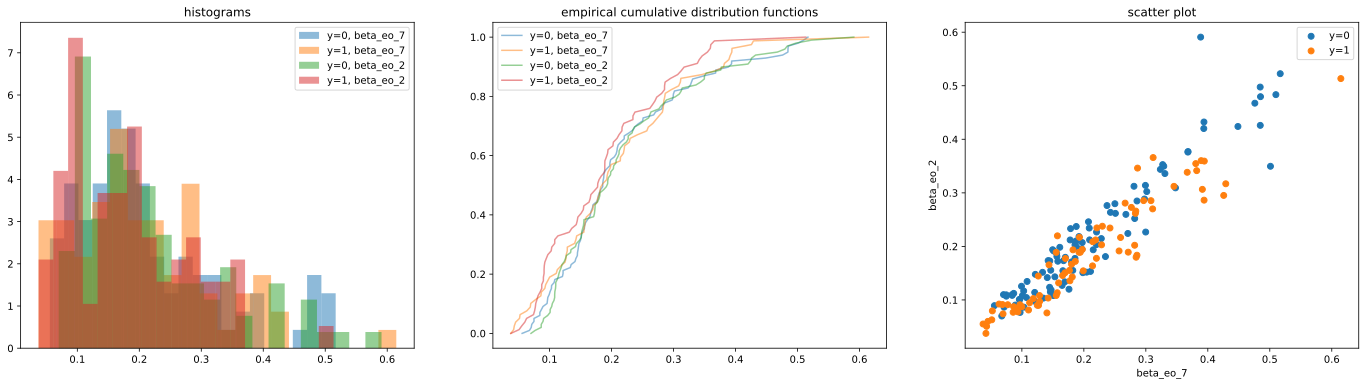

In [330]:
# plotting data in 2D with axes sampled 
# a) at random 
# b) from same electrode
# c) from same feature type
num_features = 9
num_electrodes = 48

# a) indices drawn at random
i0, i1 = np.random.randint(0, X.shape[1], size=2)

# b) same electrode, different feature (uncomment lines below)
#f0, f1 = np.random.randint(0, num_features, size=2)
#e = np.random.randint(0, num_electrodes)
#i0, i1 = f0*num_electrodes + e, f1*num_electrodes + e

# b) same feature, different electrode (uncomment lines below)
#f = np.random.randint(0, num_features)
#e0, e1 = np.random.randint(0, num_electrodes, size=2)
#i0, i1 = f*num_electrodes + e0, f*num_electrodes + e1

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
colors = ['blue', 'red']

# select features i0, i1 and separate by class
X00, X01 = X[y==0][:,i0], X[y==1][:,i0]
X10, X11 = X[y==0][:,i1], X[y==1][:,i1]
# plot cumulative distribution of feature i0 separate for each class
axes[0].hist(X00, bins=20, label='y=0, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X01, bins=20, label='y=1, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X10, bins=20, label='y=0, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].hist(X11, bins=20, label='y=1, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].set_title('histograms')
axes[0].legend()
axes[1].plot(np.sort(X00), np.linspace(0,1,X00.shape[0]), label='y=0, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X01), np.linspace(0,1,X01.shape[0]), label='y=1, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X10), np.linspace(0,1,X10.shape[0]), label='y=0, '+ feature_names[i1], alpha=0.5)
axes[1].plot(np.sort(X11), np.linspace(0,1,X11.shape[0]), label='y=1, '+ feature_names[i1], alpha=0.5)
axes[1].set_title('empirical cumulative distribution functions')
axes[1].legend()
axes[2].scatter(X00, X10, label='y=0')
axes[2].scatter(X01, X11, label='y=1')
axes[2].set_xlabel(feature_names[i0])
axes[2].set_ylabel(feature_names[i1])
axes[2].set_title('scatter plot')
axes[2].legend()

In [331]:
from sklearn.feature_selection import SelectKBest, f_classif, RFE, RFECV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, LeaveOneOut
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#Splitting data into test set and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

sc = StandardScaler()
X_scaled = sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [332]:
#Function to calculate Sensitivity and Specificity 
def calc_Se_Sp(predicted, actual):
    tp, fn, fp, tn  = metrics.confusion_matrix(actual,predicted,labels=[0,1]).ravel()
    se = 1
    sp = 1
    if (tp+fn) != 0:
        se = tp / (tp+fn)
    if (tn+fp) != 0:
        sp = tn / (tn+fp)
    return se, sp

In [333]:
#Function to perform Leave One Subject Out Cross Validation
def leave_one_subject_out_cross_validate(model, X, y):
    loco = LeaveOneOut()
    list_y_test = []
    list_model_fit = []
    list_se = []
    list_sp = []
    performance = []
    
    for train_index, test_index in loco.split(X, y):
        X_train, X_test = np.array(X[train_index]), np.array(X[test_index])
        y_train, y_test = np.array(y[train_index]), np.array(y[test_index])

        clf = model.fit(X_train, y_train)
        model_fit = model.predict(X_test)

        list_y_test = list_y_test + y_test.tolist()
        list_model_fit = list_model_fit + model_fit.tolist()
        performance.append(model.score(X_test, y_test))
        se, sp = calc_Se_Sp(model_fit, y_test)
        list_se.append(se)
        list_sp.append(sp)

    auc = metrics.roc_auc_score(list_y_test, list_model_fit)
    fpr, tpr, _ = metrics.roc_curve(np.array(list_y_test), np.array(list_model_fit))
    return [ round(np.mean(performance), 4), round(np.mean(list_se), 4), round(np.mean(list_sp), 4), round(auc, 4), fpr, tpr ]
    


In [334]:
def plot_graph(model, title):
  print("Model: ", model)
  result_LR = leave_one_subject_out_cross_validate(model, X, y)
  y_m = np.reshape(result_LR,(1,6))
  print("Accuracy: ",y_m[:,0])
  print("Specificity: ",y_m[:,1])
  print("Sensitivity: ",y_m[:,2])
  print("AUC: ",y_m[:,3])
  i = np.argmax(y_m[:,3])
  plt.title(title)
  plt.plot(y_value[i,4],y_value[i,5],color='black', linestyle='solid', marker='o',markerfacecolor='blue', markersize=6)

Model:  LogisticRegression(max_iter=10000)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Accuracy:  [0.8722]
Specificity:  [0.9389]
Sensitivity:  [0.9333]
AUC:  [0.87]


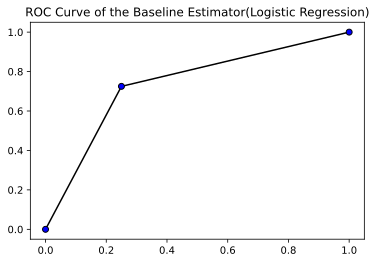

In [335]:
#Baseline LogisticRegression
baseline_lr = LogisticRegression(max_iter=10000)
plot_graph(baseline_lr, "ROC Curve of the Baseline Estimator(Logistic Regression)")

Model:  DecisionTreeClassifier()
Accuracy:  [0.7333]
Specificity:  [0.8722]
Sensitivity:  [0.8611]
AUC:  [0.7288]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


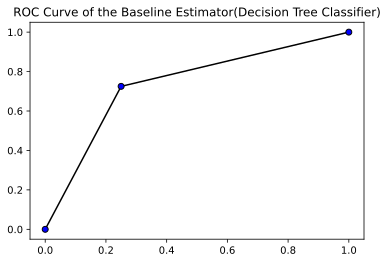

In [336]:
baseline_dc = DecisionTreeClassifier()
plot_graph(baseline_dc, "ROC Curve of the Baseline Estimator(Decision Tree Classifier)")


In [337]:
#Wrapper Method Logistic Regression 
rfe = RFE(estimator=clf, n_features_to_select=200, step=1)
pipe_rfe = Pipeline(steps=[('rfe', rfe),('classifier' , LogisticRegression())])

X_train_rfe = rfe.fit_transform(X_train_std, y_train)

parameters = [{
        'classifier__penalty' : ['l1', 'l2'],
        'classifier__max_iter' : [10000, 1000, 500, 200, 100],
        'classifier__C' : [100,10,5,1,0.1,0.01],
        'classifier__solver' : ['liblinear']
    },
    {
        'classifier__penalty' : ['l2'],
        'classifier__max_iter' : [10000, 1000, 500, 200, 100],
        'classifier__C' : [100,10,5,1,0.1,0.01],
        'classifier__solver' : ['newton-cg','lbfgs']
    }]

gdcv_rfe = GridSearchCV(estimator=pipe_rfe, param_grid=parameters, cv=5,n_jobs=-1,return_train_score=True,verbose=True)
gdcv_rfe.fit(X_train_rfe, y_train)

print(gdcv_rfe.best_score_)
print(gdcv_rfe.best_params_)
print(gdcv_rfe.best_estimator_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
0.9238916256157635
{'classifier__C': 100, 'classifier__max_iter': 1000, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Pipeline(steps=[('rfe',
                 RFE(estimator=DecisionTreeClassifier(),
                     n_features_to_select=200)),
                ('classifier',
                 LogisticRegression(C=100, max_iter=1000, penalty='l1',
                                    solver='liblinear'))])


Model:  LogisticRegression(C=100, max_iter=1000, penalty='l1', solver='liblinear')
Accuracy:  [0.8278]
Specificity:  [0.9167]
Sensitivity:  [0.9111]
AUC:  [0.825]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


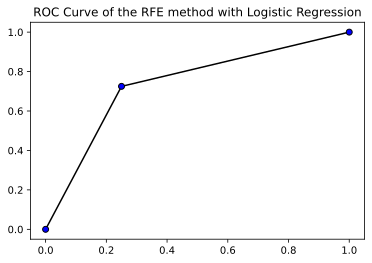

In [338]:
plot_graph(gdcv_rfe.best_estimator_['classifier'], "ROC Curve of the RFE method with Logistic Regression")


In [339]:
#Wrapper Method Decision Tree Classifier
rfe_dc = RFE(estimator=clf, n_features_to_select = 200, step=1)
pipe_rfe_dc = Pipeline(steps=[('rfe', rfe_dc),('classifier' , DecisionTreeClassifier())])

X_train_rfe_dc = rfe_dc.fit_transform(X_train_std, y_train)

parameters = { 'classifier__criterion':['gini','entropy'],'classifier__max_depth': np.arange(3, 15)}

gdcv_rfe_dc = GridSearchCV(estimator=pipe_rfe_dc, param_grid=parameters, cv=5,n_jobs=-1,return_train_score=True,verbose=True)
gdcv_rfe_dc.fit(X_train_rfe_dc, y_train)

print(gdcv_rfe_dc.best_score_)
print(gdcv_rfe_dc.best_params_)
print(gdcv_rfe_dc.best_estimator_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
0.7571428571428571
{'classifier__criterion': 'gini', 'classifier__max_depth': 4}
Pipeline(steps=[('rfe',
                 RFE(estimator=DecisionTreeClassifier(),
                     n_features_to_select=200)),
                ('classifier', DecisionTreeClassifier(max_depth=4))])


Model:  DecisionTreeClassifier(max_depth=4)
Accuracy:  [0.7889]
Specificity:  [0.8889]
Sensitivity:  [0.9]
AUC:  [0.7875]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


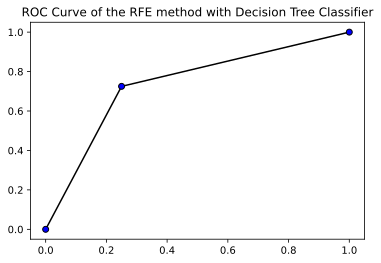

In [340]:
plot_graph(gdcv_rfe_dc.best_estimator_['classifier'], "ROC Curve of the RFE method with Decision Tree Classifier")

In [341]:
#Filtering Method ANOVA with Logistic Regression
select_anova = SelectKBest(f_classif, k=200)
pipe_anova = Pipeline(steps=[('anova', select_anova),('classifier' , LogisticRegression())])

X_train_anova = select_anova.fit_transform(X_train_std, y_train)

parameters = [{
        'classifier__penalty' : ['l1', 'l2'],
        'classifier__max_iter' : [10000, 1000, 500, 200, 100],
        'classifier__C' : [100,10,5,1,0.1,0.01],
        'classifier__solver' : ['liblinear']
    },
    {
        'classifier__penalty' : ['l2'],
        'classifier__max_iter' : [10000, 1000, 500, 200, 100],
        'classifier__C' : [100,10,5,1,0.1,0.01],
        'classifier__solver' : ['newton-cg','lbfgs']
    }]

gdcv_anova = GridSearchCV(pipe_anova, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
gdcv_anova.fit(X_train_anova, y_train)

print(gdcv_anova.best_params_)
print(gdcv_anova.best_estimator_)
print(gdcv_anova.best_score_)


Fitting 5 folds for each of 120 candidates, totalling 600 fits
{'classifier__C': 1, 'classifier__max_iter': 10000, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'}
Pipeline(steps=[('anova', SelectKBest(k=200)),
                ('classifier',
                 LogisticRegression(C=1, max_iter=10000, solver='newton-cg'))])
0.930295566502463


Model:  LogisticRegression(C=1, max_iter=10000, solver='newton-cg')
Accuracy:  [0.8722]
Specificity:  [0.9389]
Sensitivity:  [0.9333]
AUC:  [0.87]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


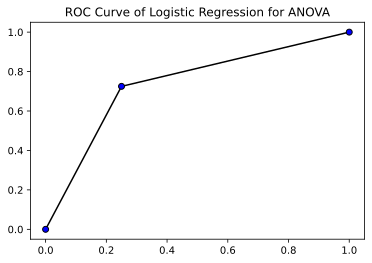

In [342]:
plot_graph(gdcv_anova.best_estimator_['classifier'], "ROC Curve of Logistic Regression for ANOVA")

In [343]:
#Filtering Method ANOVA with Decision Tree Classifier
select_anova_dc = SelectKBest(f_classif, k=200)
pipe_anova_dc = Pipeline(steps=[('anova', select_anova_dc),('classifier' , DecisionTreeClassifier())])

X_train_anova_dc = select_anova_dc.fit_transform(X_train_std, y_train)

parameters = { 'classifier__criterion':['gini','entropy'],'classifier__max_depth': np.arange(3, 15)}


gdcv_anova_dc = GridSearchCV(pipe_anova_dc, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
gdcv_anova_dc.fit(X_train_anova_dc, y_train)

print(gdcv_anova_dc.best_params_)
print(gdcv_anova_dc.best_estimator_)
print(gdcv_anova_dc.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'classifier__criterion': 'gini', 'classifier__max_depth': 6}
Pipeline(steps=[('anova', SelectKBest(k=200)),
                ('classifier', DecisionTreeClassifier(max_depth=6))])
0.7783251231527093


Model:  DecisionTreeClassifier(max_depth=6)
Accuracy:  [0.7056]
Specificity:  [0.8722]
Sensitivity:  [0.8333]
AUC:  [0.6975]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


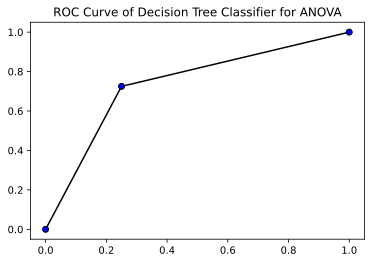

In [344]:
plot_graph(gdcv_anova_dc.best_estimator_['classifier'], "ROC Curve of Decision Tree Classifier for ANOVA")

In [345]:
#Feature Extraction with Principal Component Analysis(Logistic Regression)
pca = PCA()
pipe_pca = Pipeline(steps=[('pca', pca),('classifier' , LogisticRegression())])
pca.fit(X_train_std)
X_pca = pca.transform(X_train_std)

n_components = [20, 40, 60, 80, 100]
parameters = [{
        'classifier__penalty' : ['l1', 'l2'],
        'classifier__max_iter' : [10000, 1000, 500, 200, 100],
        'classifier__C' : [100,10,5,1,0.1,0.01],
        'classifier__solver' : ['liblinear'],
        'pca__n_components': n_components
    },
    {
        'classifier__penalty' : ['l2'],
        'classifier__max_iter' : [10000, 1000, 500, 200, 100],
        'classifier__C' : [100,10,5,1,0.1,0.01],
        'classifier__solver' : ['newton-cg','lbfgs'],
        'pca__n_components': n_components
    }]

gdcv_pca = GridSearchCV(pipe_pca, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
gdcv_pca.fit(X_pca, y_train)

print(gdcv_pca.best_params_)
print(gdcv_pca.best_estimator_)
print(gdcv_pca.best_score_)


Fitting 5 folds for each of 600 candidates, totalling 3000 fits
{'classifier__C': 5, 'classifier__max_iter': 10000, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'pca__n_components': 60}
Pipeline(steps=[('pca', PCA(n_components=60)),
                ('classifier',
                 LogisticRegression(C=5, max_iter=10000, solver='liblinear'))])
0.9443349753694582


Model:  LogisticRegression(C=5, max_iter=10000, solver='liblinear')
Accuracy:  [0.8889]
Specificity:  [0.9444]
Sensitivity:  [0.9444]
AUC:  [0.8875]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


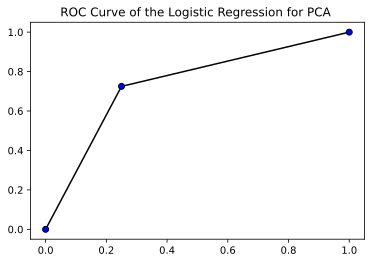

In [346]:
plot_graph(gdcv_pca.best_estimator_['classifier'], "ROC Curve of the Logistic Regression for PCA ")

In [347]:
#Feature Extraction with Principal Component Analysis(Decision Tree Classifier)
pca_dc = PCA()
pipe_pca_dc = Pipeline(steps=[('pca', pca_dc),('classifier' , DecisionTreeClassifier())])
pca_dc.fit(X_train_std)
X_pca_dc = pca_dc.transform(X_train_std)

n_components = [20, 40, 60, 80, 100]

parameters = { 'classifier__criterion':['gini','entropy'],'classifier__max_depth': np.arange(3, 15),'pca__n_components': n_components
}


gdcv_pca_dc = GridSearchCV(pipe_pca_dc, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
gdcv_pca_dc.fit(X_pca_dc, y_train)

print(gdcv_pca_dc.best_params_)
print(gdcv_pca_dc.best_estimator_)
print(gdcv_pca_dc.best_score_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
{'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'pca__n_components': 20}
Pipeline(steps=[('pca', PCA(n_components=20)),
                ('classifier', DecisionTreeClassifier(max_depth=10))])
0.7573891625615763


Model:  DecisionTreeClassifier(max_depth=10)
Accuracy:  [0.7167]
Specificity:  [0.8833]
Sensitivity:  [0.8333]
AUC:  [0.7075]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


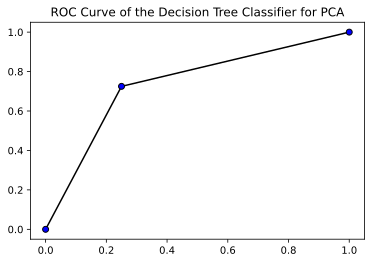

In [348]:
plot_graph(gdcv_pca_dc.best_estimator_['classifier'],"ROC Curve of the Decision Tree Classifier for PCA" )